# Improving performance

In [1]:
%matplotlib inline
# dask and distributed are extra installs
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")
topology = traj.topology

Much of the core computational effort in Contact Map Explorer is performed by MDTraj, which uses OpenMP during the nearest-neighbors calculation. This already provides excellent performance for a bottleneck in the contact map creation process. However, Contact Map Explorer also has a few other tricks to further enhance performance.

## Dask

For multi-frame contact maps and contact trajectories, Contact Map Explorer can use Dask to parallelize across frames. Note that Dask is not required to install Contact Map Explorer, so you must install Dask separately to benefit from it.

When using Dask, a few things are different:

1. You need to provide a `distributed.Client` to the `DaskContactFrequency` or `DaskContactTrajectory`.
2. You need to provide the filename (and any other arguments needed by MDTraj, instead of the trajectory itself.

Dask might not give any performance boost on a single machine, but can be very useful if parallelizing across multiple machines. Because this directly takes a `Client`, it is easy to interface this with tools like [dask-jobqueue](https://jobqueue.dask.org/en/latest/).

In [2]:
from contact_map import DaskContactFrequency, DaskContactTrajectory
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39791 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.39 GB


In [3]:
%%time
freq = DaskContactFrequency(
    client=client,
    filename="5550217/kras.xtc",
    top="5550217/kras.pdb"
)
# top must be given as keyword (passed along to mdtraj.load)

CPU times: user 281 ms, sys: 36.7 ms, total: 317 ms
Wall time: 3.82 s


In [4]:
# did it add up to give us the right number of frames?
freq.n_frames

101

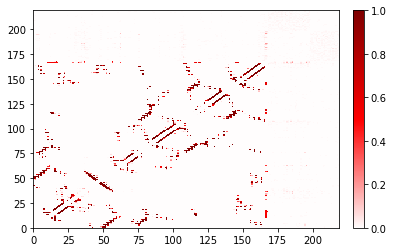

In [5]:
# do we get a familiar-looking residue map?
fig, ax = freq.residue_contacts.plot()

The same can be done for a `DaskContactTrajectory`. Here, we use the data from and compare to `contact_trajectory.ipynb`

In [6]:
traj_2 = md.load("data/gsk3b_example.h5")

topology_2 = traj_2.topology
yyg = topology_2.select('resname YYG and element != "H"')
protein = topology_2.select('protein and element != "H"')

In [7]:
%%time
dctraj = DaskContactTrajectory(
    client=client,
    query=yyg,
    haystack=protein,
    filename="data/gsk3b_example.h5",
)

CPU times: user 380 ms, sys: 10.7 ms, total: 391 ms
Wall time: 1.51 s


In [8]:
# did it add up to give us the right number of frames?
len(dctraj)

100

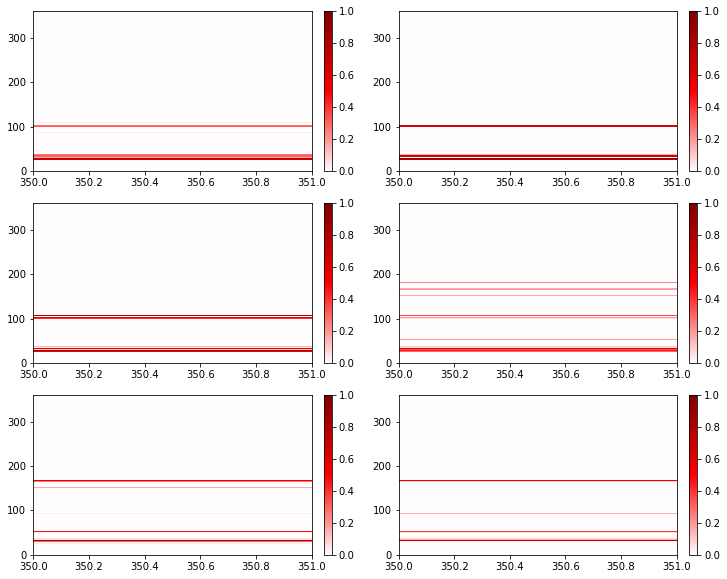

In [9]:
# do we get a familiar-looking residue map for rolling averages?
rolling_frequencies = dctraj.rolling_frequency(window_size=30, step=14)
rolling_frequencies

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
for ax, freq in zip(axs.flatten(), rolling_frequencies):
    freq.residue_contacts.plot_axes(ax=ax)
    ax.set_xlim(*freq.query_residue_range);

## "Atom slicing"

One of the internal tricks to improve performance is that we take the MDTraj trajectory that has been provided, and shrink it down to only the atoms that are included in the `query` and `haystack`. We refer to this as "atom slicing" (following terminology from MDTraj, although for performance reasons we actually implement it internally).

In most cases, you will want to atom slice. However, there are some cases where atom slicing can slow down your analysis -- mainly if the atoms needed for the contact map are *almost* all the atoms in the trajectory. For this, you can turn atom slicing off.

In [10]:
from contact_map import ContactFrequency

In [11]:
# use all the atoms except atom 0
used_atoms = list(range(1, topology.n_atoms))

In [12]:
%%time
# with atom slicing
frame_contacts = ContactFrequency(traj[0], query=used_atoms,
                                  haystack=used_atoms)

CPU times: user 314 ms, sys: 3.78 ms, total: 318 ms
Wall time: 118 ms


In [13]:
# disable atom slicing
ContactFrequency._class_use_atom_slice = False

In [14]:
%%time
# without atom slicing
frame_contacts = ContactFrequency(traj[0], query=used_atoms,
                                  haystack=used_atoms)

CPU times: user 461 ms, sys: 20.6 ms, total: 481 ms
Wall time: 289 ms


Note that this example is the worst case: the overhead for atom slicing occurs only once for an entire trajectory. However, if you're generating many single-frame contact maps, this could be relevant to you.